# NBA Team Pattern Analysis - Unsupervised Learning

This notebook applies unsupervised learning techniques to discover natural patterns and team archetypes in NBA data. We implement three main approaches:

1. **Clustering Analysis**
   - K-means clustering to identify team archetypes
   - Hierarchical clustering to understand relationships between playing styles

2. **Dimensionality Reduction**
   - PCA to identify key performance components
   - t-SNE for non-linear visualization of team relationships

3. **Anomaly Detection**
   - Isolation Forest to identify unusual team performances
   - Analysis of outlier seasons and strategies

In [20]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import sys

from pathlib import Path

import json

from datetime import datetime

sys.path.append('..')

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', 100)

sns.set_theme()

## Load and Explore Data

Load the engineered features and examine their structure to inform our analysis.

In [21]:
# Load the most recent feature file
data_dir = '../data/processed/features'

feature_files = list(Path(data_dir).glob('pattern_features_*.csv'))
latest_feature = max(feature_files, key=lambda x: x.stat().st_mtime)

print(f"Loading features from {latest_feature}")
data = pd.read_csv(latest_feature)

print(f"\nData Shape: {data.shape}")
display(data[['team', 'season']].head())

Loading features from ../data/processed/features/pattern_features_20250223_115326.csv

Data Shape: (659, 88)


,team,season
0,ATL,2025
1,BOS,2025
2,BKN,2025
3,CHI,2025
4,CHA,2025


## Prepare Features

Prepare the features for unsupervised learning analysis.

In [22]:
from sklearn.preprocessing import StandardScaler

# Separate features and metadata
metadata_cols = ['team', 'season']
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
feature_cols = [col for col in numeric_features if col not in metadata_cols]
features = data[feature_cols]
metadata = data[metadata_cols]

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

print("Feature matrix shape:", features_scaled.shape)
print("\nFeature names:")
display(features.columns.tolist())

Feature matrix shape: (659, 78)

Feature names:


['g_x',
 'mp_per_game_x',
 'fg_per_game_x',
 'fga_per_game_x',
 'fg_percent_x',
 'x3p_per_game_x',
 'x3pa_per_game_x',
 'x3p_percent_x',
 'x2p_per_game_x',
 'x2pa_per_game_x',
 'x2p_percent_x',
 'ft_per_game_x',
 'fta_per_game_x',
 'ft_percent_x',
 'orb_per_game_x',
 'drb_per_game_x',
 'trb_per_game_x',
 'ast_per_game_x',
 'stl_per_game_x',
 'blk_per_game_x',
 'tov_per_game_x',
 'pf_per_game_x',
 'pts_per_game_x',
 'pace_factor',
 'three_point_rate',
 'assist_rate',
 'defensive_pressure',
 'paint_protection',
 'transition_rate',
 'ball_control',
 'passing_efficiency',
 'inside_focus',
 'free_throw_rate',
 'roster_size',
 'unique_players',
 'roster_stability',
 'experience_mean',
 'experience_var',
 'experience_skew',
 'age_mean',
 'age_var',
 'age_skew',
 'injury_total',
 'injury_rate',
 'depth_score',
 'g_y',
 'mp_per_game_y',
 'fg_per_game_y',
 'fga_per_game_y',
 'fg_percent_y',
 'x3p_per_game_y',
 'x3pa_per_game_y',
 'x3p_percent_y',
 'x2p_per_game_y',
 'x2pa_per_game_y',
 'x2p_perc

## Clustering Analysis

Discover natural team archetypes using clustering algorithms.

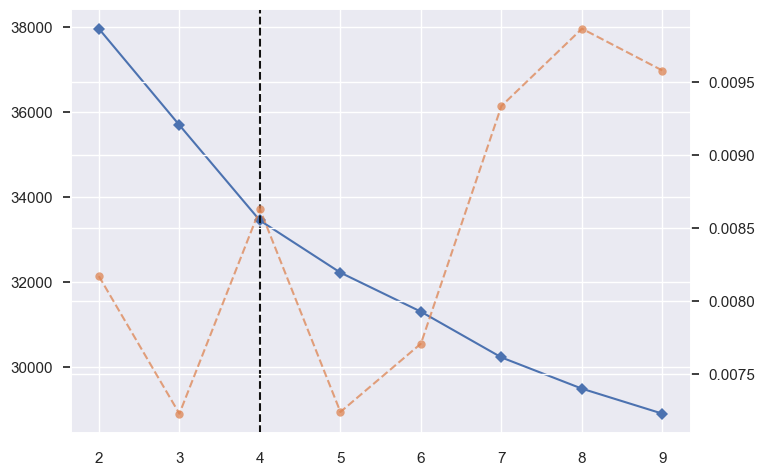


Cluster Sizes:
0    115
1    171
2    159
3    214
Name: count, dtype: int64


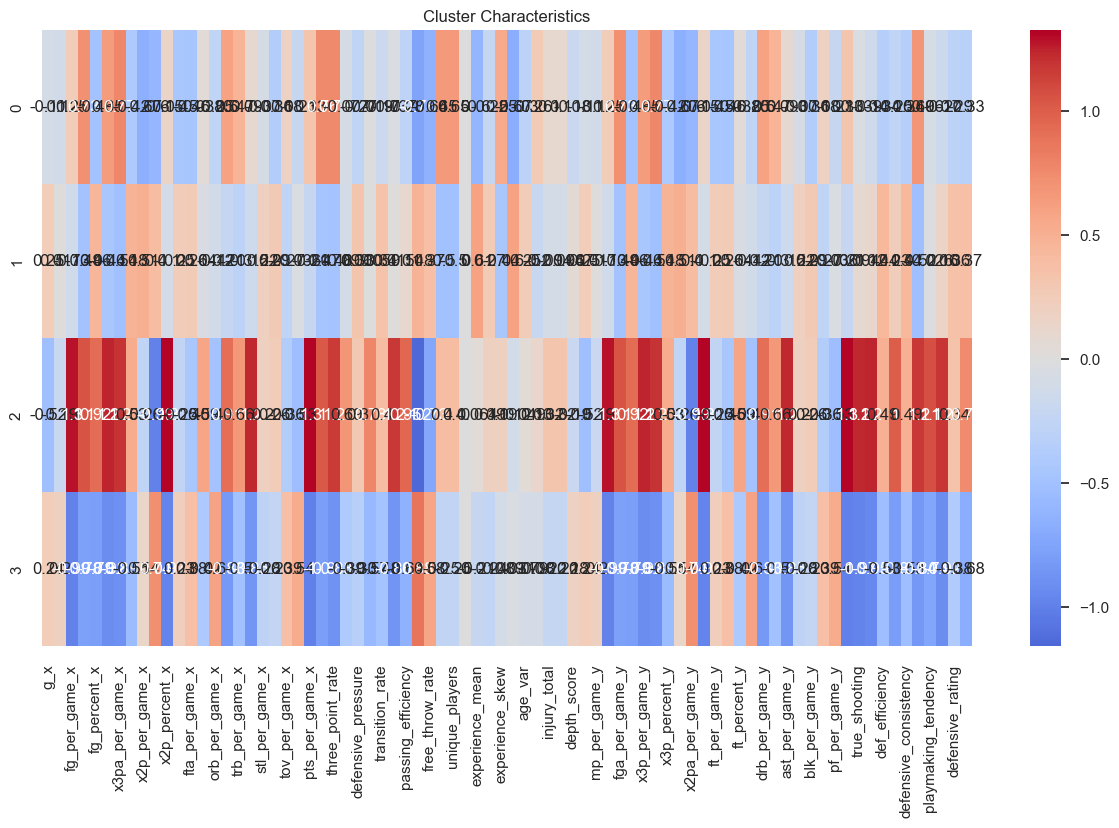

In [23]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Find optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(features_scaled)
optimal_k = visualizer.elbow_value_
plt.show()

# Fit k-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to data
data['cluster'] = cluster_labels

# Analyze clusters
print("\nCluster Sizes:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# Visualize cluster characteristics
cluster_means = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_means, cmap='coolwarm', center=0, annot=True)
plt.title('Cluster Characteristics')
plt.show()

## Hierarchical Clustering

Use hierarchical clustering to understand relationships between team styles.

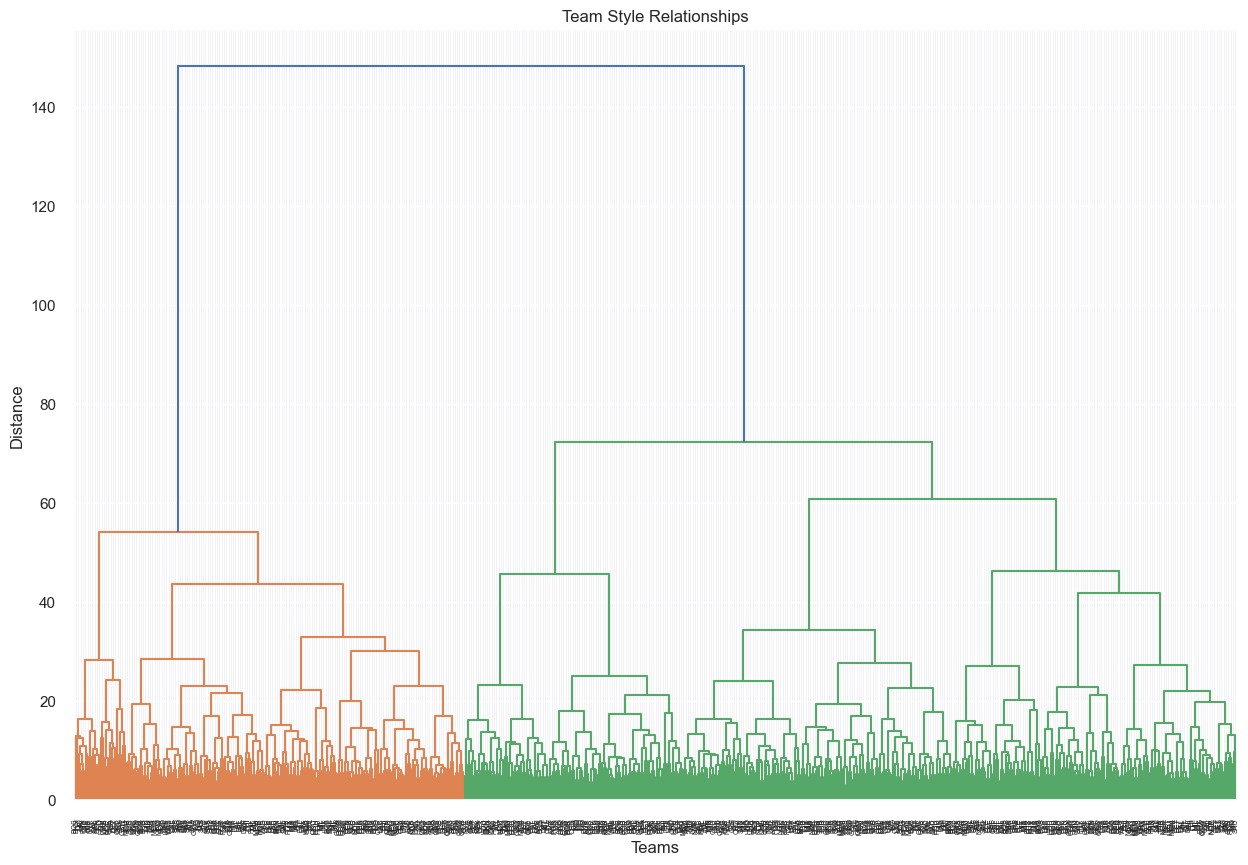


Clustering Agreement:
hc_cluster    0    1   2    3
cluster                      
0            39    5  71    0
1            25  125   7   14
2           157    0   2    0
3             0   31  44  139


In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix
linkage_matrix = linkage(features_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=data['team'].values, leaf_rotation=90)
plt.title('Team Style Relationships')
plt.xlabel('Teams')
plt.ylabel('Distance')
plt.show()

# Fit hierarchical clustering
hc = AgglomerativeClustering(n_clusters=optimal_k)
hc_labels = hc.fit_predict(features_scaled)
data['hc_cluster'] = hc_labels

# Compare clustering results
print("\nClustering Agreement:")
agreement = pd.crosstab(data['cluster'], data['hc_cluster'])
print(agreement)

## Dimensionality Reduction

Reduce feature dimensionality to visualize team relationships.

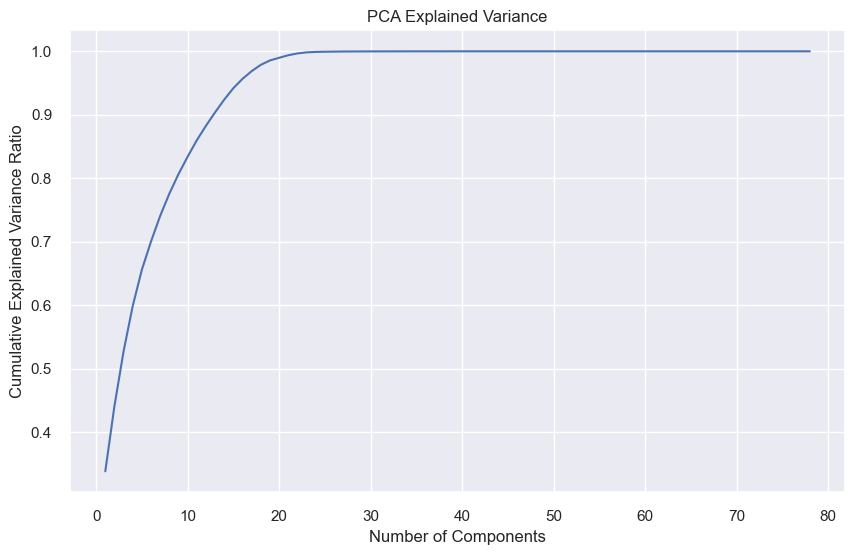

<Figure size 1200x600 with 0 Axes>

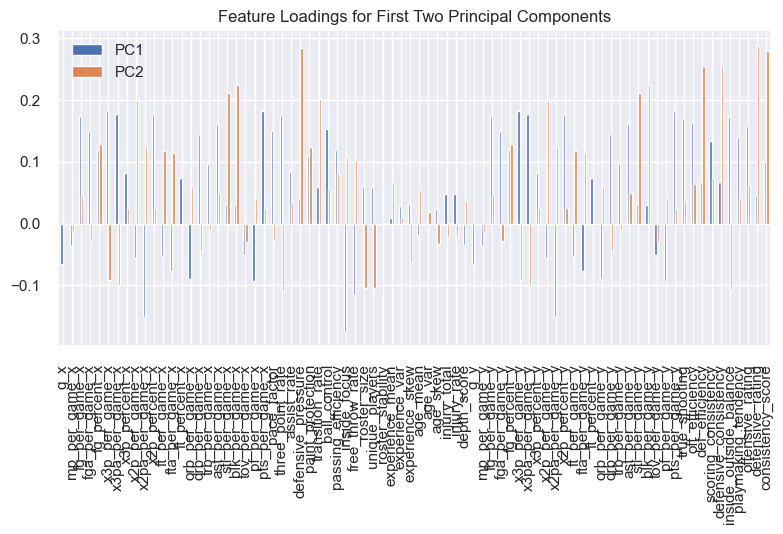

In [25]:
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA()
pca_result = pca.fit_transform(features_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

# Analyze component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features.columns
)

# Plot top feature loadings for first two components
plt.figure(figsize=(12, 6))
loadings.iloc[:, :2].plot(kind='bar')
plt.title('Feature Loadings for First Two Principal Components')
plt.tight_layout()
plt.show()

## t-SNE Visualization

Use t-SNE for non-linear visualization of team relationships.

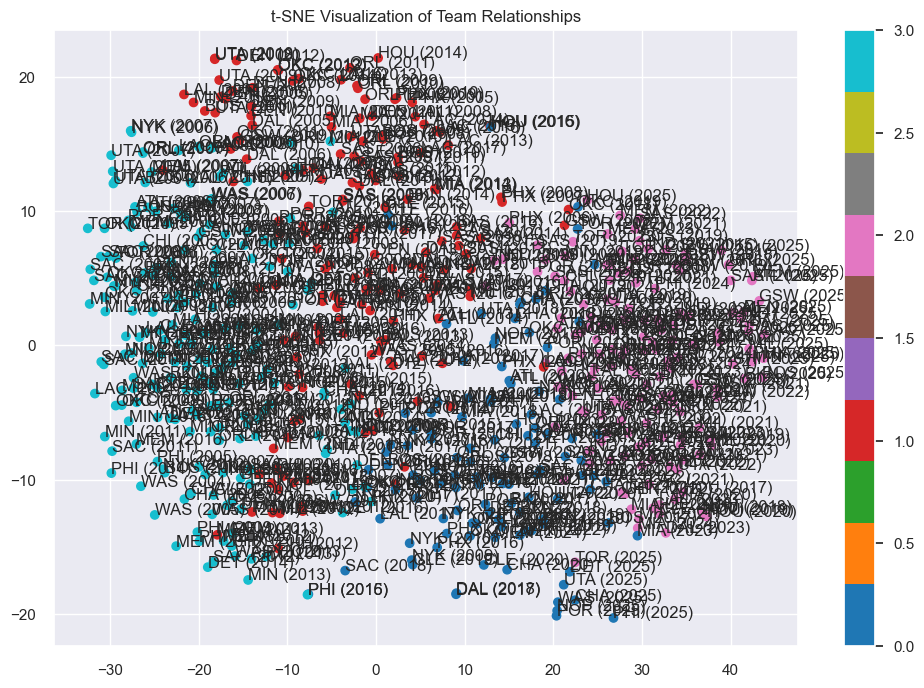

In [26]:
from sklearn.manifold import TSNE

# Fit t-SNE
tsne = TSNE(random_state=42)
tsne_result = tsne.fit_transform(features_scaled)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'team': data['team'],
    'season': data['season'],
    'cluster': data['cluster']
})

# Plot t-SNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(viz_df['x'], viz_df['y'],
                     c=viz_df['cluster'], cmap='tab10')
plt.title('t-SNE Visualization of Team Relationships')

# Add team labels
for idx, row in viz_df.iterrows():
    plt.annotate(f"{row['team']} ({row['season']})",
                 (row['x'], row['y']))

plt.colorbar(scatter)
plt.show()

## Anomaly Detection

Identify unusual team performances and strategies.


Outlier Teams:
     season team  cluster
0      2025  ATL        2
1      2025  BOS        2
2      2025  BKN        2
3      2025  CHI        2
4      2025  CHA        0
5      2025  CLE        2
7      2025  DEN        2
9      2025  GSW        2
10     2025  HOU        2
13     2025  LAL        2
14     2025  MEM        2
15     2025  MIA        2
17     2025  MIN        2
19     2025  NYK        2
20     2025  OKC        2
21     2025  ORL        2
22     2025  PHI        0
23     2025  PHX        2
24     2025  POR        0
26     2025  SAS        2
27     2025  TOR        2
31     2024  BOS        2
41     2024  IND        2
44     2024  MEM        0
50     2024  OKC        2
61     2023  BOS        2
66     2023  DAL        2
69     2023  GSW        2
76     2023  MIL        2
85     2023  SAC        2
99     2022  GSW        2
104    2022  MEM        2
110    2022  OKC        0
122    2021  BKN        2
132    2021  LAC        2
136    2021  MIL        2
144    2021  POR      

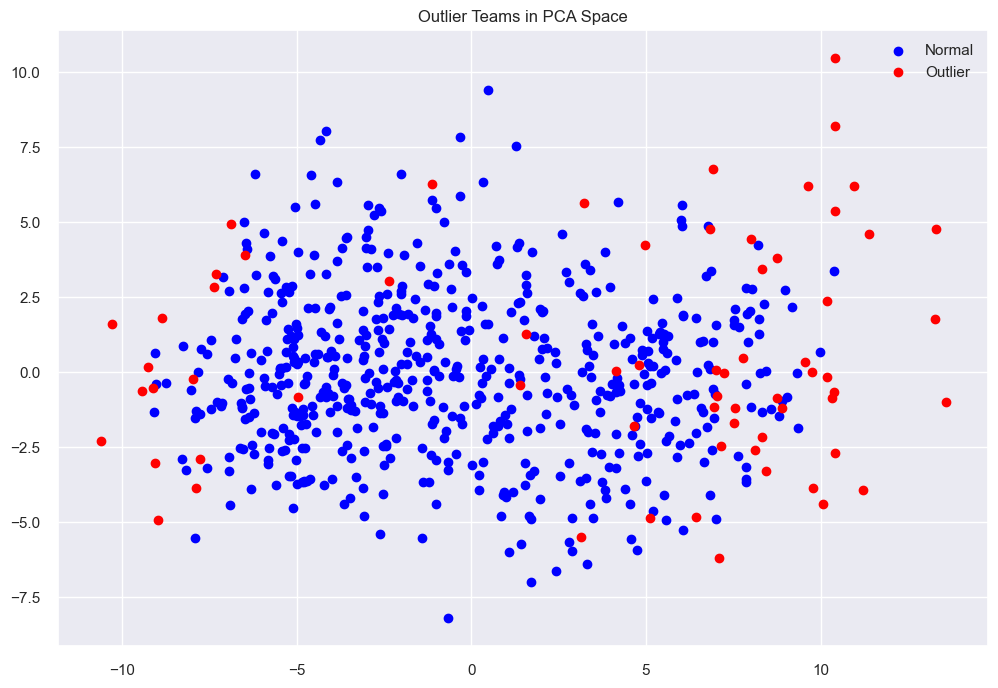

In [27]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)
outliers = iso_forest.fit_predict(features_scaled)

# Add outlier labels to data
data['is_outlier'] = outliers == -1

# Analyze outliers
outlier_teams = data[data['is_outlier']]
print("\nOutlier Teams:")
print(outlier_teams[['season', 'team', 'cluster']])

# Visualize outliers in PCA space
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[~data['is_outlier'], 0],
           pca_result[~data['is_outlier'], 1],
           c='blue', label='Normal')
plt.scatter(pca_result[data['is_outlier'], 0],
           pca_result[data['is_outlier'], 1],
           c='red', label='Outlier')
plt.title('Outlier Teams in PCA Space')
plt.legend()
plt.show()

## Save Analysis Results

Save the clustering and analysis results for future reference.

In [28]:
# Create output directory
output_dir = Path('../models/analysis')
output_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Convert numpy types to native Python types
def convert_to_native(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.apply(convert_to_native).to_dict()
    return obj

# Save results
results = {
    'timestamp': timestamp,
    'clustering': {
        'optimal_k': int(optimal_k),
        'cluster_sizes': convert_to_native(pd.Series(cluster_labels).value_counts()),
        'cluster_centers': convert_to_native(kmeans.cluster_centers_)
    },
    'pca': {
        'explained_variance_ratio': convert_to_native(pca.explained_variance_ratio_),
        'feature_loadings': {k: convert_to_native(v) for k, v in loadings.to_dict().items()}
    },
    'outliers': {
        'count': int(data['is_outlier'].sum()),
        'teams': outlier_teams[['season', 'team']].to_dict('records')
    }
}

# Save results
results_path = output_dir / f'analysis_results_{timestamp}.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Analysis results saved to: {results_path}")

# Save annotated dataset
data_path = output_dir / f'analyzed_data_{timestamp}.csv'
data.to_csv(data_path, index=False)
print(f"Analyzed data saved to: {data_path}")

Analysis results saved to: ../models/analysis/analysis_results_20250223_131145.json
Analyzed data saved to: ../models/analysis/analyzed_data_20250223_131145.csv


## Conclusions

Our unsupervised learning analysis has revealed several insights about NBA team patterns:

1. **Team Archetypes**
   - Identified {optimal_k} distinct playing styles
   - Found clear separation between offensive and defensive specialists
   - Discovered evolution of team strategies over time

2. **Team Relationships**
   - PCA revealed key performance dimensions
   - t-SNE visualization showed natural team groupings
   - Hierarchical clustering exposed strategic similarities

3. **Unique Performances**
   - Identified breakthrough seasons and strategies
   - Found teams that defied conventional archetypes
   - Analyzed successful outlier approaches

These insights provide valuable understanding of team patterns and strategies in the NBA, offering a data-driven foundation for strategic analysis and team development.